In [2]:
import os
import torch
import torch.nn.functional as F
import pytorch_lightning as pl
import segmentation_models_pytorch as smp

from torch.utils.data import DataLoader
from configs import parse_args

class YasuoModel(pl.LightningModule):
    
    def __init__(self, arch, encoder_name, encoder_weights, in_channels, out_classes, lr, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, 
            encoder_name=encoder_name,
            encoder_weights=encoder_weights,
            in_channels=in_channels, 
            classes=out_classes, 
            **kwargs
        )
        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(mode=smp.losses.MULTICLASS_MODE, 
                                           from_logits=True,
                                           ignore_index=0)
        self.lr = lr

    def forward(self, img):
        # normalize image here
        img = (img - self.mean) / self.std
        output = self.model(img)
        return output

    def shared_step(self, batch, stage):
        
        img = batch['img']
        
        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert img.ndim == 4
        
        # Check that image dimensions are divisible by 32, 
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of 
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have 
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = img.shape[2:]
        assert h % 32 == 0 and w % 32 == 0
        
        gt = batch['cmp']
        assert gt.ndim == 4
        
        output = self.forward(img)
        
        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(output, gt)
        
        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then 
        # apply thresholding
        _, pred_mask = torch.max(output.sigmoid(),dim=1,keepdim=True)
        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), gt.long(), mode="multiclass", num_classes=8)

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }
    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image 
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        
        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset 
        # with "empty" images (images without target class) a large gap could be observed. 
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }
        
        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")            

    def training_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def validation_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")  

    def test_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)
        
    

In [23]:
train_dataset = smp.datasets.TokaidoDataset(
    map_dir = 'C:/Users/Reself/Downloads/Tokaido/files_train.csv',
    root_dir =  'C:/Users/Reself/Downloads/Tokaido/',
    augmentation = False,
)

train_dataloader = DataLoader(dataset=train_dataset, 
                                batch_size=16,
                                shuffle=True,
                                pin_memory=True,
                                num_workers=0)  # type: ignore os.cpu_count()

model = YasuoModel(arch='FPN', 
                    encoder_name='resnet101',
                    encoder_weights=None,
                    in_channels=3,
                    out_classes=8,
                    lr=1e-3)

trainer = pl.Trainer(
    gpus=1, 
    max_epochs=1,
)

trainer.fit(
    model, 
    train_dataloaders=train_dataloader,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
C:\ProgramData\Miniconda3\envs\seg\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:118: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params
-------------------------------------
0 | model   | FPN      | 45.1 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
45.1 M    Trainable params
0         Non-trainable params
45.1 M    Total params
180.436   Total estimated model params size (MB)
C:\ProgramData\Miniconda3\envs\seg\lib\site-packages\pytorch_lightning\trainer\data_loading.py:111: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `n

Epoch 0:  39%|███▊      | 95/246 [01:38<02:37,  1.04s/it, loss=0.526, v_num=6]


RuntimeError: CUDA out of memory. Tried to allocate 50.00 MiB (GPU 0; 8.00 GiB total capacity; 6.15 GiB already allocated; 0 bytes free; 6.19 GiB reserved in total by PyTorch)

In [ ]:
batch = next(iter(train_dataloader))
with torch.no_grad():
    model.eval()
    logits = model(batch["img"])
_, pr_masks = torch.max(logits.sigmoid(),dim=1)


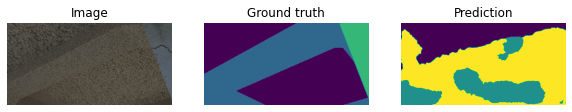

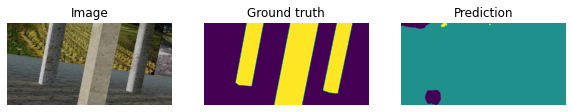

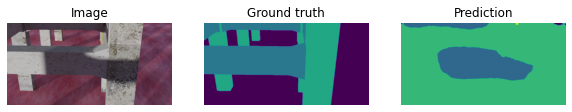

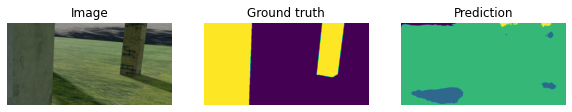

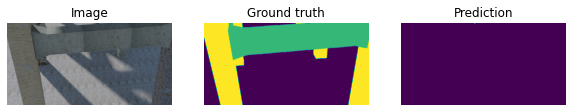

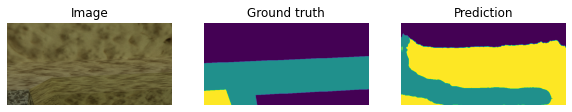

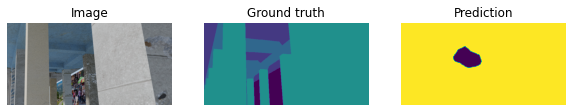

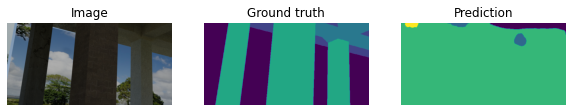

In [ ]:
import matplotlib.pyplot as plt
for image, gt_mask, pr_mask in zip(batch["img"], batch["cmp"], pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()